In [2]:
import numpy as np

test_data = np.load('test_data.npy', allow_pickle=True)

#artists, duration_ms, popularity, release_date, tempo, key, liveness
x_test, y_test = test_data[..., :-1], test_data[..., -1]

print(x_test.shape, y_test.shape)

(10000, 6) (10000,)


In [3]:
import torch
from torch import nn
import torch.nn.functional as F

class InputFeatures(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(18907, 8)
    
    def forward(self, x):
        result = []
        for i in x[..., 0]:
            result.append(self.emb(torch.LongTensor(i).cuda()).sum(0))
        result = torch.stack(result)
        return torch.cat([result, torch.FloatTensor(x[..., 1:].astype(np.float32)).cuda()], dim=1)

class Body(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(13, 32),
            nn.LayerNorm(32),
            nn.GELU(),
            nn.Linear(32, 32),
            nn.LayerNorm(32),
            nn.GELU(),
            nn.Linear(32, 32),
            nn.LayerNorm(32),
            nn.GELU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.f(x)
    
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            InputFeatures(),
            Body()
        )
    
    def forward(self, x):
        return self.f(x)

In [4]:
model = Model().cuda()
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

Model(
  (f): Sequential(
    (0): InputFeatures(
      (emb): Embedding(18907, 8)
    )
    (1): Body(
      (f): Sequential(
        (0): Linear(in_features=13, out_features=32, bias=True)
        (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (2): GELU()
        (3): Linear(in_features=32, out_features=32, bias=True)
        (4): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (5): GELU()
        (6): Linear(in_features=32, out_features=32, bias=True)
        (7): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (8): GELU()
        (9): Linear(in_features=32, out_features=1, bias=True)
      )
    )
  )
)

In [5]:
total_loss = 0
batch_size = 256
all_out = []

for i in range(0, len(x_test), batch_size):
    x_batch = x_test[i:i+batch_size]
    y_batch = y_test[i:i+batch_size]

    out = model(x_batch)
    label = torch.FloatTensor(y_batch.astype(np.float32)).unsqueeze(-1).cuda()
    all_out += out
    loss = F.mse_loss(out, label)
    total_loss += loss.item()

print(f'Test Loss: {total_loss/(i+1)}')

Test Loss: 0.00010848376446654932


Text(0, 0.5, 'Frequency')

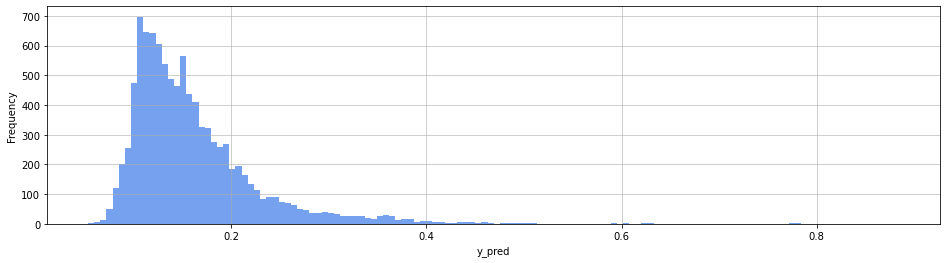

In [52]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(16, 4))
# plt.plot(all_out, 'o', markersize=2)

#all_out = np.array(list(map(lambda x: x.detach().cpu(), all_out)))

plt.figure(figsize=(16, 4))
n, bins, patches = plt.hist(x=all_out, bins='auto', color='#75a1ee')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)

plt.xlabel('y_pred')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

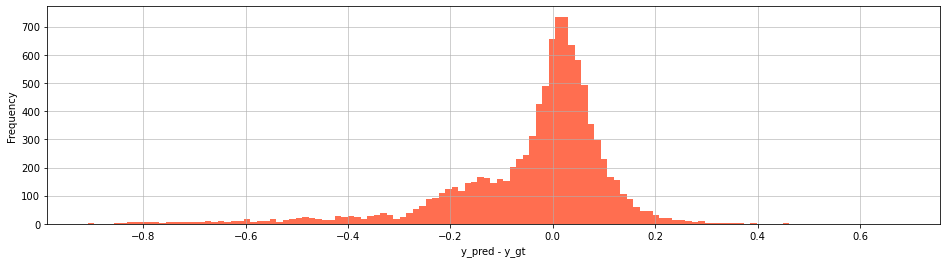

In [44]:
diff = all_out-y_test
# diff = np.array(list(map(lambda x: x.detach().cpu(), diff)))

plt.figure(figsize=(16, 4))
n, bins, patches = plt.hist(x=diff, bins='auto', color='#ff6e50')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)

plt.xlabel('y_pred - y_gt')
plt.ylabel('Frequency')